# SC3000 Project 1 (Balancing a Pole on a Cart)

## Dependency Installation

Please read the README.md to install the relevant dependencies using pip before running this notebook.

## Contributions


## Project done by
1. Keith Ang Kee Chun (U2220349G)
2. Oh ShuYi (U2220108H)

### Project Description
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart. In this project, we will develop a Reinforcement Learning (RL) agent. The trained agent makes the decision to push the cart to the left or right based on the cart position, velocity, and the pole angle, angular velocity.

### Action Space
The action is an *ndarray* with shape (1,) which can take values {0, 1} indicating pushing the cart to the left or right, respectively. Note that the velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it.

### State Space
We define *observation* as a state (they are used interchangeably here). The observation is an *ndarray* with shape (4,) with the values corresponding to the following positions and velocities:

| **Observation[n]** | **Observation**       | **Min**             | **Max**           |
| ------- | --------------------- | ------------------- | ----------------- |
| **0**   | Cart Position         | \-4.8               | 4.8               |
| **1**   | Cart Velocity         | \-Inf               | Inf               |
| **2**   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| **3**   | Pole Angular Velocity | \-Inf               | Inf               |

## Condition
The challenge is to balance the pole for **500 states per episode**.

The pole is said to be balanced if:
* Pole Angle is at most ±12°
* Cart Position is at most ±2.4 (center of the cart reaches the edge of the display)

Violation to any of the above two conditions defines an unbalanced pole.

## Solution

We are considering the use of 2 reinforcement learning agents:

1. Q-learning
2. PPO(KIV)

## Importing Dependencies

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from sklearn.model_selection import GridSearchCV

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

# github code
# def show_video():
#   mp4list = glob.glob('video/*.mp4')
#   if len(mp4list) > 0:
#     mp4 = mp4list[0]
#     video = io.open(mp4, 'r+b').read()
#     encoded = base64.b64encode(video)
#     ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
#   else:
#     print("Could not find video")

## Loading CartPole Environment

In [ ]:
env = gym.make("CartPole-v1", render_mode='rgb_array')

print(env.action_space)
print(env.observation_space)

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.01349501  0.01122996 -0.01449281  0.02072091]


In [ ]:
gym.version

<module 'gym.version' from '/usr/local/lib/python3.10/dist-packages/gym/version.py'>

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.01004599 -0.37859973 -0.00790247  0.59700614]
Reward for this step: 1.0
Is this round done? False


In [ ]:
##Function to record Cumulative Rewards per episode

observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward

print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0



Development of an RL agent. Demonstrate the correctness of the implementation by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action. Print the values of the state and chosen action in Jupyter notebook
1. Developing RL agent based on cartpole's position and velocity
2. Developing RL agent based on cartpole's velocity and pole angle
3. Compare and conclude which policy is better using Q-learning


In [ ]:
#Uses the cart's position and velocity in making thepolicy
#x -> Pposition of cart such that we can eep the cartpole relatively central (minimise displacement)
#v -> Minimise movement of the cart when marking adjustments

def x_v_policy_agent(obs):
    x, v = obs[0:2]  # obs[0]: x-> position of cart, obs[2]: v-> velocity of cart

    #abs value of x < 0.05 -> want to keey it as close to the centre as possible
    if abs(x) < 0.05:
        #if cart is close to the centre, cuse velocity to balance the pole
        #if it is +ve means it moves right so shift cart left (step 0)
        #if it is -ve means it moves left so shift cart right (step 1)
        return 0 if v>0 else 1
    else:
        #if cart is far from the centre, cuse cart's position to balance the pole
        #if it is +ve means it is moved towards the right so shift cart left (step 0)
        #if it is -ve means it is moved towards the left so shift cart right (step 1)
        return 0 if x>0 else 1

In [ ]:
def test_policy(policy_func, n_scenario = 1000, max_actions = 510, verbose=False):
    final_rewards = []
    for episode in range(n_scenario):
        if verbose and episode % 50 == 0:
            print(episode)
        episode_rewards = 0
        obs = env.reset()  # reset to a random position
        for step in range(max_actions):
            action = policy_func(obs)
            obs, reward, done, info = env.step(action)
            episode_rewards += reward
            if done:
                break
        final_rewards.append(episode_rewards)
    return final_rewards

def plot_policy(final_rewards, policy_name:str=''):
    fig = plt.plot(range(len(final_rewards)), final_rewards)
    plt.grid()
    plt.title(policy_name + " Mean Reward {:.2f}, Std Reward {:.2f}".format(np.mean(final_rewards), np.min(final_rewards)))
    plt.ylabel('Cum Reward')
    plt.xlabel('Iteration')
    plt.ylim(0, max(final_rewards)*1.1)
    return fig

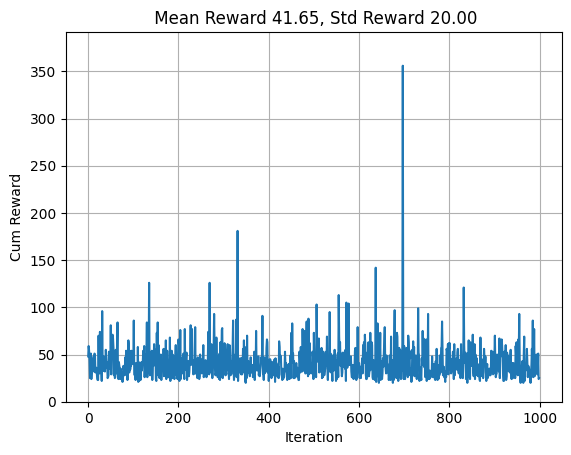

In [ ]:
x_v_reward = test_policy(x_v_policy_agent)
plot_policy(x_v_reward)

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
counter = 0
while True:
    env.render()
    #your agent goes here
    action = x_v_policy_agent(observation)
    observation, reward, done, info = env.step(action)
    if done: break
env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## Use of pole angle and velocity in our policy

In [ ]:
def theta_v_policy_agent(obs):
    v, theta = obs[1:3]
    if abs(theta) < 0.05:
        return 0 if v>0 else 1 # shift left if cart moving to the right, vice versa
    else:
        return 0 if theta<0 else 1 # shift left if pole is tilting to the right, vice versa

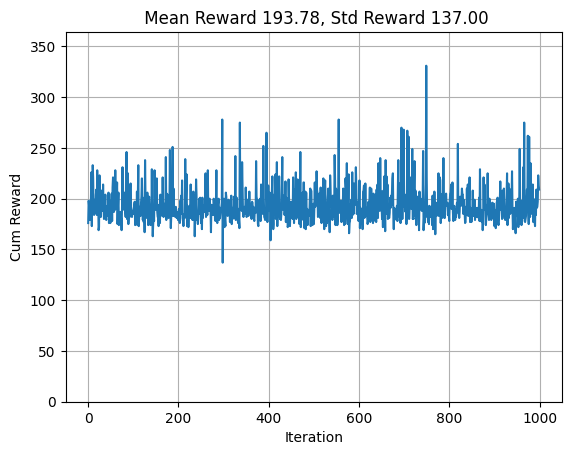

In [ ]:
theta_v_reward = test_policy(theta_v_policy_agent)
plot_policy(theta_v_reward)

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
counter = 0
while True:
    env.render()
    #your agent goes here
    action = theta_v_policy_agent(observation)
    observation, reward, done, info = env.step(action)
    if done: break
env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## Pole angle and angular velocity

In [ ]:
def theta_thetadot_policy_agent(obs):
    theta, thetadot = obs[2:4]
    if abs(theta) < 0.05:
        return 0 if thetadot<0 else 1
    else:
        return 0 if theta<0 else 1

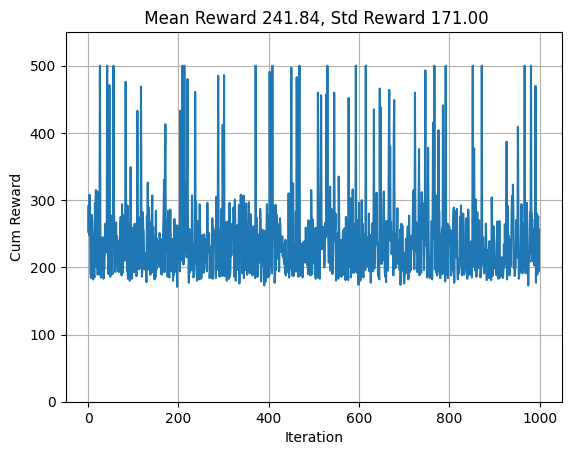

In [ ]:
theta_thetadot_reward = test_policy(theta_thetadot_policy_agent)
plot_policy(theta_thetadot_reward)

In [ ]:
env = RecordVideo(gym.make("CartPole-v1", render_mode = 'rgb_array'), "./video")
observation = env.reset()
counter = 0
while True:
    env.render()
    #your agent goes here
    action = theta_thetadot_policy_agent(observation)
    observation, reward, done, info = env.step(action)
    if done: break
env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [ ]:
!pip freeze

 ## Observations
 From our observation of using different combinations of states in the observation space, we found that using Pole Angle and Angular Velocity yield the highest mean reward of 241.51 as compared to the other states.


# Q-Learning (DQN)

To further investigate the effectiveness of the RL agent, we decided to use Q-learning to see if there would be an improvement. We first initalise our Q-table to store the Q-values for each state-action pair. Then, we have to discretize the state values as the cartpole environment is over a range of continous values. We then set our bin size to 20, randomly initialized the Q-Values using a uniform distribution and used a small epsilon value so as to leverage more on the exploitation of the Q-learning algorithm.

In [ ]:
import gym
import numpy as np

# Define the environment
env = gym.make('CartPole-v1')

# Initialize the Q-table
q_table = np.random.uniform(low=-1, high=1, size=([20,20,20,20] + [env.action_space.n]))

# Set hyperparameters
num_episodes = 50000
epsilon = 0.25
learning_rate = 0.2
discount_factor = 0.995

# Define the bins for discretizing the continuous state space
def get_bins():
    return [
        np.linspace(-4.8, 4.8, num=20),
        np.linspace(-4, 4, num=20),
        np.linspace(-0.418, 0.418, num=20),
        np.linspace(-4, 4, num=20)
    ]

# Discretize the state space
def discretize_state(state, bins):
    index = []
    for i in range(len(state)):
        index.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(index)

# Choose an action based on the Q-values
def select_action(state, q_table, eps):
    if np.random.uniform() < eps:
        return env.action_space.sample()
    else:
        return np.argmax(q_table[state])

# Update the Q-table based on the observed state, action, next state, and reward
def update_q_table(q_table, state, action, next_state, reward, lr, gamma):
    old_value = q_table[state + (action,)]
    next_max = np.max(q_table[next_state])
    new_value = (1 - lr) * old_value + lr * (reward + gamma * next_max)
    q_table[state + (action,)] = new_value
    return q_table

# Run a single episode and return the total reward
def run_episode(env, q_table, eps, bins):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = discretize_state(obs, bins)
        action = select_action(state, q_table, eps)
        obs, reward, done, _ = env.step(action)
        next_state = discretize_state(obs, bins)
        q_table = update_q_table(q_table, state, action, next_state, reward, learning_rate, discount_factor)
        total_reward += reward
    return total_reward

# Train the agent for a specified number of episodes
def train_agent(env, q_table, num_episodes, eps, bins):
    rewards = []
    for i in range(num_episodes):
        total_reward = run_episode(env, q_table, eps, bins)
        rewards.append(total_reward)
        if (i + 1) % 100 == 0:
            avg_reward = np.mean(rewards[-100:])
            print(f"Episode {i+1}/{num_episodes}, average reward: {avg_reward:.2f}")
    return q_table, rewards

# Train the agent
q_table_trained, rewards = train_agent(env, q_table, num_episodes, epsilon, get_bins())


Episode 100/50000, average reward: 17.05
Episode 200/50000, average reward: 18.40
Episode 300/50000, average reward: 24.68
Episode 400/50000, average reward: 58.50
Episode 500/50000, average reward: 98.41
Episode 600/50000, average reward: 104.61
Episode 700/50000, average reward: 112.68
Episode 800/50000, average reward: 123.75
Episode 900/50000, average reward: 115.07
Episode 1000/50000, average reward: 122.55
Episode 1100/50000, average reward: 125.14
Episode 1200/50000, average reward: 133.89
Episode 1300/50000, average reward: 139.82
Episode 1400/50000, average reward: 121.23
Episode 1500/50000, average reward: 123.43
Episode 1600/50000, average reward: 118.65
Episode 1700/50000, average reward: 137.56
Episode 1800/50000, average reward: 148.05
Episode 1900/50000, average reward: 106.41
Episode 2000/50000, average reward: 136.26
Episode 2100/50000, average reward: 132.98
Episode 2200/50000, average reward: 118.95
Episode 2300/50000, average reward: 130.80
Episode 2400/50000, avera

In [ ]:
avg_reward = np.mean(rewards)
print(f"Average reward over 100 episodes: {avg_reward:.2f}")

Average reward over 100 episodes: 280.28


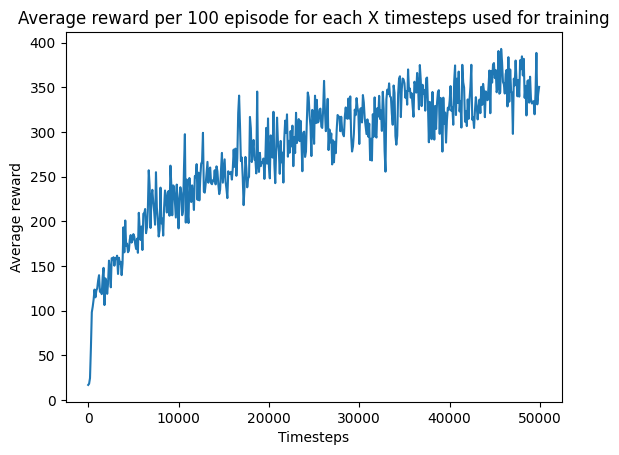

In [ ]:
import matplotlib.pyplot as plt

# Calculate the average reward per 100 episodes
avg_rewards = [np.mean(rewards[i:i+100]) for i in range(0, num_episodes, 100)]

# Plot the graph
plt.plot(range(0, num_episodes, 100), avg_rewards)
plt.xlabel('Timesteps')
plt.ylabel('Average reward')
plt.title("Average reward per 100 episode for each X timesteps used for training")
plt.show()

In [ ]:
import gym
import numpy as np

# Define the environment
env = gym.make('CartPole-v1')

# Initialize the Q-table
q_table = np.random.uniform(low=-1, high=1, size=([20,20,20,20] + [env.action_space.n]))

# Set hyperparameters
num_episodes = 15000
epsilon = 0.25
learning_rate = 0.2
discount_factor = 0.995

# Define the bins for discretizing the continuous state space
def get_bins():
    return [
        np.linspace(-4.8, 4.8, num=20),
        np.linspace(-4, 4, num=20),
        np.linspace(-0.418, 0.418, num=20),
        np.linspace(-4, 4, num=20)
    ]

# Discretize the state space
def discretize_state(state, bins):
    index = []
    for i in range(len(state)):
        index.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(index)

# Choose an action based on the Q-values
def select_action(state, q_table, eps):
    if np.random.uniform() < eps:
        return env.action_space.sample()
    else:
        return np.argmax(q_table[state])

# Update the Q-table based on the observed state, action, next state, and reward
def update_q_table(q_table, state, action, next_state, reward, lr, gamma):
    old_value = q_table[state + (action,)]
    next_max = np.max(q_table[next_state])
    new_value = (1 - lr) * old_value + lr * (reward + gamma * next_max)
    q_table[state + (action,)] = new_value
    return q_table

# Run a single episode and return the total reward
def run_episode(env, q_table, eps, bins):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = discretize_state(obs, bins)
        action = select_action(state, q_table, eps)
        obs, reward, done, _ = env.step(action)
        next_state = discretize_state(obs, bins)
        q_table = update_q_table(q_table, state, action, next_state, reward, learning_rate, discount_factor)
        total_reward += reward
    return total_reward

# Train the agent for a specified number of episodes
def train_agent(env, q_table, num_episodes, eps, bins):
    rewards = []
    for i in range(num_episodes):
        total_reward = run_episode(env, q_table, eps, bins)
        rewards.append(total_reward)
        if (i + 1) % 50 == 0:
            avg_reward = np.mean(rewards[-50:])
            print(f"Episode {i+1}/{num_episodes}, average reward: {avg_reward:.2f}")
    return q_table, rewards

# Train the agent
q_table_trained, rewards = train_agent(env, q_table, num_episodes, epsilon, get_bins())


Episode 50/15000, average reward: 23.98
Episode 100/15000, average reward: 25.68
Episode 150/15000, average reward: 20.80
Episode 200/15000, average reward: 29.30
Episode 250/15000, average reward: 25.28
Episode 300/15000, average reward: 34.02
Episode 350/15000, average reward: 48.22
Episode 400/15000, average reward: 56.08
Episode 450/15000, average reward: 65.22
Episode 500/15000, average reward: 65.70
Episode 550/15000, average reward: 96.26
Episode 600/15000, average reward: 91.22
Episode 650/15000, average reward: 89.86
Episode 700/15000, average reward: 78.94
Episode 750/15000, average reward: 87.62
Episode 800/15000, average reward: 112.48
Episode 850/15000, average reward: 113.26
Episode 900/15000, average reward: 93.04
Episode 950/15000, average reward: 104.24
Episode 1000/15000, average reward: 99.18
Episode 1050/15000, average reward: 130.18
Episode 1100/15000, average reward: 110.40
Episode 1150/15000, average reward: 130.12
Episode 1200/15000, average reward: 124.82
Episo

In [ ]:
avg_reward = np.mean(rewards)
print(f"Average reward over 50 episodes: {avg_reward:.2f}")

Average reward over 50 episodes: 235.53


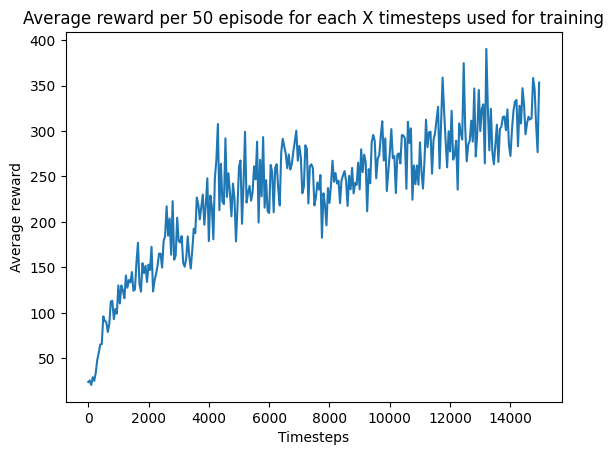

In [ ]:
import matplotlib.pyplot as plt

# Calculate the average reward per 100 episodes
avg_rewards = [np.mean(rewards[i:i+50]) for i in range(0, num_episodes, 50)]

# Plot the graph
plt.plot(range(0, num_episodes, 50), avg_rewards)
plt.xlabel('Timesteps')
plt.ylabel('Average reward')
plt.title("Average reward per 50 episode for each X timesteps used for training")
plt.show()

In [ ]:
import gym
import numpy as np

# Define the environment
env = gym.make('CartPole-v1')

# Initialize the Q-table
q_table = np.random.uniform(low=-1, high=1, size=([20,20,20,20] + [env.action_space.n]))

# Set hyperparameters
num_episodes = 30000
epsilon = 0.25
learning_rate = 0.2
discount_factor = 0.995

# Define the bins for discretizing the continuous state space
def get_bins():
    return [
        np.linspace(-4.8, 4.8, num=20),
        np.linspace(-4, 4, num=20),
        np.linspace(-0.418, 0.418, num=20),
        np.linspace(-4, 4, num=20)
    ]

# Discretize the state space
def discretize_state(state, bins):
    index = []
    for i in range(len(state)):
        index.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(index)

# Choose an action based on the Q-values
def select_action(state, q_table, eps):
    if np.random.uniform() < eps:
        return env.action_space.sample()
    else:
        return np.argmax(q_table[state])

# Update the Q-table based on the observed state, action, next state, and reward
def update_q_table(q_table, state, action, next_state, reward, lr, gamma):
    old_value = q_table[state + (action,)]
    next_max = np.max(q_table[next_state])
    new_value = (1 - lr) * old_value + lr * (reward + gamma * next_max)
    q_table[state + (action,)] = new_value
    return q_table

# Run a single episode and return the total reward
def run_episode(env, q_table, eps, bins):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = discretize_state(obs, bins)
        action = select_action(state, q_table, eps)
        obs, reward, done, _ = env.step(action)
        next_state = discretize_state(obs, bins)
        q_table = update_q_table(q_table, state, action, next_state, reward, learning_rate, discount_factor)
        total_reward += reward
    return total_reward

# Train the agent for a specified number of episodes
def train_agent(env, q_table, num_episodes, eps, bins):
    rewards = []
    for i in range(num_episodes):
        total_reward = run_episode(env, q_table, eps, bins)
        rewards.append(total_reward)
        if (i + 1) % 20 == 0:
            avg_reward = np.mean(rewards[-20:])
            print(f"Episode {i+1}/{num_episodes}, average reward: {avg_reward:.2f}")
    return q_table, rewards

# Train the agent
q_table_trained, rewards = train_agent(env, q_table, num_episodes, epsilon, get_bins())


Episode 20/30000, average reward: 18.90
Episode 40/30000, average reward: 19.60
Episode 60/30000, average reward: 21.65
Episode 80/30000, average reward: 14.90
Episode 100/30000, average reward: 20.75
Episode 120/30000, average reward: 17.85
Episode 140/30000, average reward: 17.80
Episode 160/30000, average reward: 14.55
Episode 180/30000, average reward: 20.90
Episode 200/30000, average reward: 36.95
Episode 220/30000, average reward: 49.20
Episode 240/30000, average reward: 42.10
Episode 260/30000, average reward: 60.45
Episode 280/30000, average reward: 69.40
Episode 300/30000, average reward: 73.55
Episode 320/30000, average reward: 107.30
Episode 340/30000, average reward: 85.75
Episode 360/30000, average reward: 57.20
Episode 380/30000, average reward: 107.60
Episode 400/30000, average reward: 94.55
Episode 420/30000, average reward: 98.10
Episode 440/30000, average reward: 96.60
Episode 460/30000, average reward: 69.60
Episode 480/30000, average reward: 74.40
Episode 500/30000,

In [ ]:
avg_reward = np.mean(rewards)
print(f"Average reward over 20 episodes: {avg_reward:.2f}")

Average reward over 20 episodes: 274.08


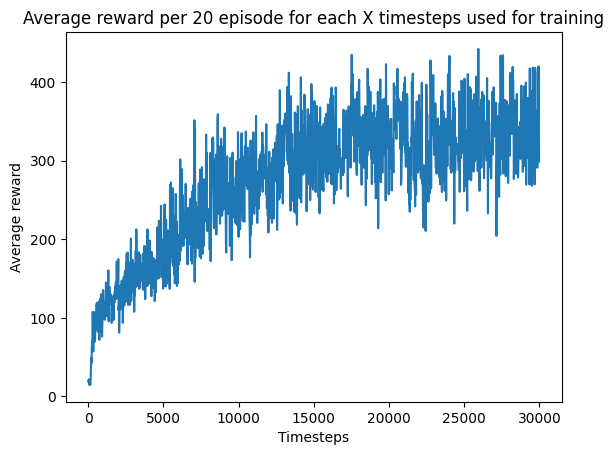

In [ ]:
import matplotlib.pyplot as plt

# Calculate the average reward per 100 episodes
avg_rewards = [np.mean(rewards[i:i+20]) for i in range(0, num_episodes, 20)]

# Plot the graph
plt.plot(range(0, num_episodes, 20), avg_rewards)
plt.xlabel('Timesteps')
plt.ylabel('Average reward')
plt.title("Average reward per 20 episode for each X timesteps used for training")
plt.show()

In [ ]:
import gym
import numpy as np

# Define the environment
env = gym.make('CartPole-v1')

# Initialize the Q-table
q_table = np.random.uniform(low=-1, high=1, size=([20,20,20,20] + [env.action_space.n]))

# Set hyperparameters
num_episodes = 100000
epsilon = 0.25
learning_rate = 0.2
discount_factor = 0.995

# Define the bins for discretizing the continuous state space
def get_bins():
    return [
        np.linspace(-4.8, 4.8, num=20),
        np.linspace(-4, 4, num=20),
        np.linspace(-0.418, 0.418, num=20),
        np.linspace(-4, 4, num=20)
    ]

# Discretize the state space
def discretize_state(state, bins):
    index = []
    for i in range(len(state)):
        index.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(index)

# Choose an action based on the Q-values
def select_action(state, q_table, eps):
    if np.random.uniform() < eps:
        return env.action_space.sample()
    else:
        return np.argmax(q_table[state])

# Update the Q-table based on the observed state, action, next state, and reward
def update_q_table(q_table, state, action, next_state, reward, lr, gamma):
    old_value = q_table[state + (action,)]
    next_max = np.max(q_table[next_state])
    new_value = (1 - lr) * old_value + lr * (reward + gamma * next_max)
    q_table[state + (action,)] = new_value
    return q_table

# Run a single episode and return the total reward
def run_episode(env, q_table, eps, bins):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = discretize_state(obs, bins)
        action = select_action(state, q_table, eps)
        obs, reward, done, _ = env.step(action)
        next_state = discretize_state(obs, bins)
        q_table = update_q_table(q_table, state, action, next_state, reward, learning_rate, discount_factor)
        total_reward += reward
    return total_reward

# Train the agent for a specified number of episodes
def train_agent(env, q_table, num_episodes, eps, bins):
    rewards = []
    for i in range(num_episodes):
        total_reward = run_episode(env, q_table, eps, bins)
        rewards.append(total_reward)
        if (i + 1) % 100 == 0:
            avg_reward = np.mean(rewards[-100:])
            print(f"Episode {i+1}/{num_episodes}, average reward: {avg_reward:.2f}")
    return q_table, rewards

# Train the agent
q_table_trained, rewards = train_agent(env, q_table, num_episodes, epsilon, get_bins())


Episode 100/100000, average reward: 33.53
Episode 200/100000, average reward: 40.09
Episode 300/100000, average reward: 54.85
Episode 400/100000, average reward: 78.96
Episode 500/100000, average reward: 96.68
Episode 600/100000, average reward: 105.33
Episode 700/100000, average reward: 110.22
Episode 800/100000, average reward: 99.86
Episode 900/100000, average reward: 99.63
Episode 1000/100000, average reward: 105.70
Episode 1100/100000, average reward: 97.48
Episode 1200/100000, average reward: 122.22
Episode 1300/100000, average reward: 125.36
Episode 1400/100000, average reward: 122.09
Episode 1500/100000, average reward: 119.07
Episode 1600/100000, average reward: 136.88
Episode 1700/100000, average reward: 120.00
Episode 1800/100000, average reward: 126.88
Episode 1900/100000, average reward: 144.54
Episode 2000/100000, average reward: 131.32
Episode 2100/100000, average reward: 143.75
Episode 2200/100000, average reward: 150.47
Episode 2300/100000, average reward: 154.67
Episo

In [ ]:
avg_reward = np.mean(rewards)
print(f"Average reward over 100 episodes: {avg_reward:.2f}")

Average reward over 100 episodes: 303.29


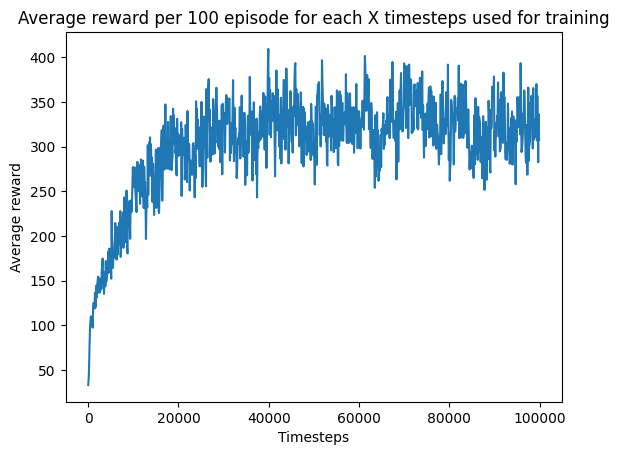

In [ ]:
import matplotlib.pyplot as plt

# Calculate the average reward per 100 episodes
avg_rewards = [np.mean(rewards[i:i+100]) for i in range(0, num_episodes, 100)]

# Plot the graph
plt.plot(range(0, num_episodes, 100), avg_rewards)
plt.xlabel('Timesteps')
plt.ylabel('Average reward')
plt.title("Average reward per 100 episode for each X timesteps used for training")
plt.show()

In [ ]:
import gym
import numpy as np

# Define the environment
env = gym.make('CartPole-v1')

# Initialize the Q-table
q_table = np.random.uniform(low=-1, high=1, size=([20,20,20,20] + [env.action_space.n]))

# Set hyperparameters
num_episodes = 60000
epsilon = 0.25
learning_rate = 0.2
discount_factor = 0.995

# Define the bins for discretizing the continuous state space
def get_bins():
    return [
        np.linspace(-4.8, 4.8, num=20),
        np.linspace(-4, 4, num=20),
        np.linspace(-0.418, 0.418, num=20),
        np.linspace(-4, 4, num=20)
    ]

# Discretize the state space
def discretize_state(state, bins):
    index = []
    for i in range(len(state)):
        index.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(index)

# Choose an action based on the Q-values
def select_action(state, q_table, eps):
    if np.random.uniform() < eps:
        return env.action_space.sample()
    else:
        return np.argmax(q_table[state])

# Update the Q-table based on the observed state, action, next state, and reward
def update_q_table(q_table, state, action, next_state, reward, lr, gamma):
    old_value = q_table[state + (action,)]
    next_max = np.max(q_table[next_state])
    new_value = (1 - lr) * old_value + lr * (reward + gamma * next_max)
    q_table[state + (action,)] = new_value
    return q_table

# Run a single episode and return the total reward
def run_episode(env, q_table, eps, bins):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = discretize_state(obs, bins)
        action = select_action(state, q_table, eps)
        obs, reward, done, _ = env.step(action)
        next_state = discretize_state(obs, bins)
        q_table = update_q_table(q_table, state, action, next_state, reward, learning_rate, discount_factor)
        total_reward += reward
    return total_reward

# Train the agent for a specified number of episodes
def train_agent(env, q_table, num_episodes, eps, bins):
    rewards = []
    for i in range(num_episodes):
        total_reward = run_episode(env, q_table, eps, bins)
        rewards.append(total_reward)
        if (i + 1) % 100 == 0:
            avg_reward = np.mean(rewards[-100:])
            print(f"Episode {i+1}/{num_episodes}, average reward: {avg_reward:.2f}")
    return q_table, rewards

# Train the agent
q_table_trained, rewards = train_agent(env, q_table, num_episodes, epsilon, get_bins())


Episode 100/60000, average reward: 38.33
Episode 200/60000, average reward: 85.96
Episode 300/60000, average reward: 99.39
Episode 400/60000, average reward: 102.77
Episode 500/60000, average reward: 108.66
Episode 600/60000, average reward: 117.23
Episode 700/60000, average reward: 125.07
Episode 800/60000, average reward: 112.14
Episode 900/60000, average reward: 126.99
Episode 1000/60000, average reward: 115.42
Episode 1100/60000, average reward: 149.84
Episode 1200/60000, average reward: 120.29
Episode 1300/60000, average reward: 151.83
Episode 1400/60000, average reward: 132.94
Episode 1500/60000, average reward: 144.59
Episode 1600/60000, average reward: 133.03
Episode 1700/60000, average reward: 132.88
Episode 1800/60000, average reward: 142.04
Episode 1900/60000, average reward: 158.02
Episode 2000/60000, average reward: 151.71
Episode 2100/60000, average reward: 146.64
Episode 2200/60000, average reward: 194.29
Episode 2300/60000, average reward: 130.41
Episode 2400/60000, ave

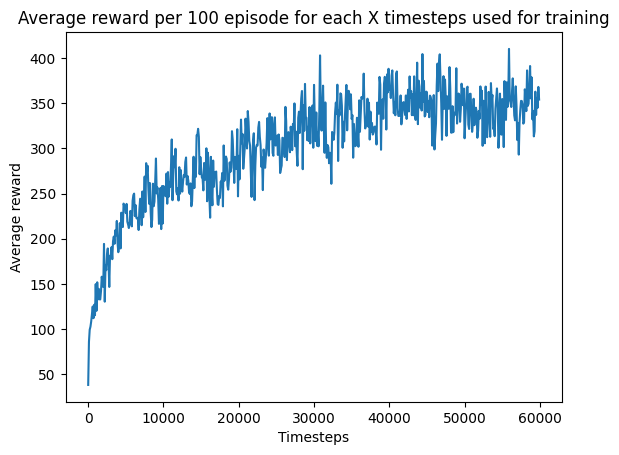

In [ ]:
import matplotlib.pyplot as plt

# Calculate the average reward per 100 episodes
avg_rewards = [np.mean(rewards[i:i+100]) for i in range(0, num_episodes, 100)]

# Plot the graph
plt.plot(range(0, num_episodes, 100), avg_rewards)
plt.xlabel('Timesteps')
plt.ylabel('Average reward')
plt.title("Average reward per 100 episode for each X timesteps used for training")
plt.show()

In [ ]:
avg_reward = np.mean(rewards)
print(f"Average reward over 100 episodes: {avg_reward:.2f}")

Average reward over 100 episodes: 301.64


In [ ]:
print(q_table)

NameError: name 'q_table' is not defined